In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from torch_geometric.datasets.dblp import DBLP
import os
import os.path as osp

Read DBLP dataset

In [3]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [4]:
data['author'].x

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [5]:
torch.unique(data['author'].x)

tensor([0., 1.])

In [6]:
data['paper'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
torch.unique(data['paper'].x)

tensor([0., 1., 2., 3., 4., 5.])

In [8]:
data['term'].x

tensor([[-0.6924, -0.4659,  1.1540,  ...,  0.9178,  0.1995, -0.6360],
        [ 1.2031, -0.4003,  0.0740,  ...,  1.3262, -0.3325,  0.8198],
        [ 0.3748,  0.5731,  0.4802,  ...,  1.1522,  0.6010, -0.4309],
        ...,
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.1724, -0.2723, -1.3368,  ..., -0.0881,  0.0225,  0.1166],
        [ 0.2197,  0.0253,  0.1220,  ...,  0.0871, -0.5351, -0.4949]])

In [9]:
data['conference'].num_nodes

20

Training data for GMM 

In [10]:
#Original author node features
author = data['author'].x.tolist()
author_df = pd.DataFrame(author)
author_df['class'] = data['author'].y.tolist()
author_df

,0,1,2,3,4,5,6,7,8,9,...,325,326,327,328,329,330,331,332,333,class
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Fit GMM to 4 author types

In [11]:
author_class0 = author_df[author_df['class'] == 0].drop(['class'], axis = 1)
author_class0

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
author_class1 = author_df[author_df['class'] == 1].drop(['class'], axis = 1)
#author_class1

In [13]:
author_class2 = author_df[author_df['class'] == 2].drop(['class'], axis = 1)
#author_class2

In [14]:
author_class3 = author_df[author_df['class'] == 3].drop(['class'], axis = 1)
#author_class3

In [15]:
#Original paper node features
paper = data['paper'].x.tolist()
paper_df = pd.DataFrame(paper)
paper_df

,0,1,2,3,4,5,6,7,8,9,...,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#Original term node features
term = data['term'].x.tolist()
term_df = pd.DataFrame(term)
term_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.69241,-0.465920,1.154000,0.066483,-0.676250,0.693760,0.53680,0.206780,0.12607,-0.36763,...,1.32870,0.074684,-0.34136,0.873600,-0.065725,-0.780720,0.902000,0.917840,0.19945,-0.63601
1,1.20310,-0.400280,0.073991,1.041500,0.051753,0.411660,-0.98656,-0.794660,0.36033,0.54428,...,0.38339,-0.572190,-0.16915,0.139840,-0.774300,-0.061819,0.218870,1.326200,-0.33245,0.81980
2,0.37481,0.573140,0.480170,-0.056679,0.704740,0.715910,0.32591,-0.099446,0.51029,0.64193,...,0.74200,-0.163610,0.44295,0.400600,-0.235400,-0.276530,-0.203020,1.152200,0.60099,-0.43094
3,0.54148,-0.419840,-0.334260,-0.412010,0.112200,1.047600,0.47449,-0.751110,0.40817,0.74477,...,0.45971,-0.064420,-0.27582,1.021800,-0.037676,-0.405910,1.231400,0.472220,0.69127,0.37195
4,0.16408,0.927990,-1.573400,-0.859870,0.369720,0.852800,0.20269,-0.620400,-1.00010,0.29585,...,0.66077,-0.952820,-0.36583,1.758900,-0.497820,0.599950,0.756170,1.384800,-0.11633,-0.62254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7718,0.41800,0.249680,-0.412420,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.00066,-0.65660,...,-0.29871,-0.157490,-0.34758,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.11514,-0.78581
7719,-1.01450,1.239400,-1.618500,-1.033600,-0.056811,0.270890,-0.38817,-0.353350,-0.51784,1.10460,...,0.97806,0.158320,-0.54189,-0.186700,-0.334690,0.391300,0.524110,-0.059546,-0.78882,-0.71343
7720,0.41800,0.249680,-0.412420,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.00066,-0.65660,...,-0.29871,-0.157490,-0.34758,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.11514,-0.78581
7721,0.17239,-0.272270,-1.336800,1.170600,-0.621270,-0.528470,1.32210,0.145990,-0.15398,-1.24660,...,-0.76113,-0.583970,-0.13828,0.907620,-0.114690,-0.746190,0.723290,-0.088101,0.02252,0.11660


Fit and sample GMM

In [17]:
new_features_dict = {}

In [18]:
def sample_features(model,node_type, n_samples):

    smpls = model.sample(n_samples)
    print("no of class {} node samples - {}".format(node_type, n_samples))
    return smpls[0]

In [19]:
def fit_sample_gm(df_class, node_type, n_samples):
    #fit
    model = GaussianMixture(n_components=1, covariance_type='full', random_state = 0)
    model.fit(df_class)
    #print("Mean for nodetype", node_type,model.means_)
    #sample
    smpls = sample_features(model, node_type, n_samples)
    new_features_dict[node_type] = smpls

Class 1 - Author,
Class 0 - Paper,
Class 2 - Term,
Class 3 - Conference

In [20]:
G = nx.read_gexf("DBLP_four_area_hgen.gexf")
n_samples_author = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1))
n_samples_paper = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0))
n_samples_term = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2))

In [21]:
fit_sample_gm(author_class0, 'author0', 1150)

no of class author0 node samples - 1150


In [22]:
fit_sample_gm(author_class1, 'author1', 1150)

no of class author1 node samples - 1150


In [23]:
fit_sample_gm(author_class2, 'author2', 1150)

no of class author2 node samples - 1150


In [24]:
fit_sample_gm(author_class3, 'author3', 1151)

no of class author3 node samples - 1151


In [25]:
fit_sample_gm(paper_df, 'paper', n_samples_paper)

no of class paper node samples - 2988


In [26]:
fit_sample_gm(term_df, 'term', n_samples_term)

no of class term node samples - 3646


Plot node feature distributions

In [27]:
new_features_dict

{'author0': array([[-0.53202077, -0.11451794,  0.03972733, ...,  0.07034736,
         -0.08845135,  0.07814282],
        [ 0.09251921,  0.40770018, -0.00501428, ..., -0.01640461,
         -0.02354932,  0.58584887],
        [ 0.03204444,  0.48243233,  0.02709211, ...,  0.03744712,
         -0.17843438, -0.31492099],
        ...,
        [ 0.21253148, -0.24131837,  0.04077031, ..., -0.03042403,
         -0.18481116,  0.18699045],
        [-0.00117328, -0.27286841,  0.00128427, ...,  0.02996142,
          0.003995  , -0.14154054],
        [ 0.01526648, -0.28868607, -0.03783261, ..., -0.04372027,
         -0.08956662,  0.03312007]]),
 'author1': array([[-0.07743486,  0.08205665, -0.12138325, ...,  0.22072984,
         -0.13223758, -0.07727355],
        [-0.16477074,  0.14837825,  0.00269914, ...,  0.10475423,
          0.06365601,  0.18680886],
        [ 0.18598069,  0.27685242, -0.0048582 , ..., -0.16327911,
          0.03922716,  0.2569347 ],
        ...,
        [ 0.1231111 ,  0.0172231

In [28]:
def plot_dist(node_list0,node_list1,node_list2,node_list3):    

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.distplot(node_list0, label='author 0', ax=ax , hist= False)
    sns.distplot(node_list1, label='author 1', ax=ax , hist= False)
    sns.distplot(node_list2, label='author 2', ax=ax , hist= False)
    sns.distplot(node_list3, label='author 3', ax=ax , hist= False)

    ax.set_title('Dist plots')
    ax.legend()
    plt.show()

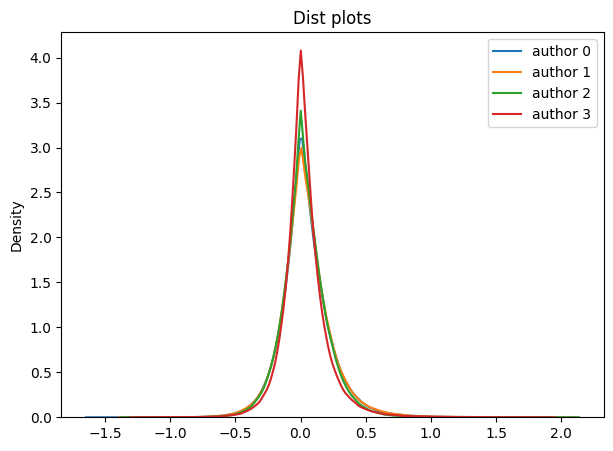

In [29]:
#Normal Distributions of 4 node types after fitting Gaussian Mixture Models 
plot_dist(new_features_dict['author0'],new_features_dict['author1'],new_features_dict['author2'],new_features_dict['author3'])

Setting to 0.0 if value is less than 0.5 else 1.0

In [30]:
def convert_to_binary(df):
    return df.applymap(lambda x: 0.0 if x<0.5 else 1.0)

In [31]:
def convert_to_discrete(df):
    return df.applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.5>=x<0.6 
                       else 2.0 if 0.6>=x<0.7 else 3.0 if 0.7>=x<0.8 else 4.0 if 0.8>=x<0.9 
                       else 5.0 if 0.9>=x<1.0 else 1.0)

In [32]:
#Author

In [33]:
authorclass0_sampled = convert_to_binary(pd.DataFrame(new_features_dict['author0']))
authorclass0_sampled['class'] = 0
authorclass0_sampled

,0,1,2,3,4,5,6,7,8,9,...,325,326,327,328,329,330,331,332,333,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [34]:
authorclass1_sampled = convert_to_binary(pd.DataFrame(new_features_dict['author1']))
authorclass1_sampled['class'] = 1
#authorclass1_sampled

In [35]:
authorclass2_sampled = convert_to_binary(pd.DataFrame(new_features_dict['author2']))
authorclass2_sampled['class'] = 2
#authorclass2_sampled

In [36]:
authorclass3_sampled = convert_to_binary(pd.DataFrame(new_features_dict['author3']))
authorclass3_sampled['class'] = 3
#authorclass3_sampled

In [37]:
author_node_features = pd.concat([authorclass0_sampled,authorclass1_sampled,authorclass2_sampled,
                                  authorclass3_sampled],ignore_index=True)

In [38]:
class1_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1)
author_nodeids = [int(x) for x in list(class1_node_subset.keys())]
author_node_features.insert(0,'nodeId',author_nodeids)

In [39]:
author_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,325,326,327,328,329,330,331,332,333,class
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,4596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4597,4597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4598,4598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4599,4599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [40]:
#Paper

In [41]:
paper_node_features = convert_to_discrete(pd.DataFrame(new_features_dict['paper']))

In [42]:
paper_node_features

,0,1,2,3,4,5,6,7,8,9,...,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
np.unique(paper_node_features)

array([0., 1., 2., 3., 4., 5.])

In [44]:
class0_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0)
paper_nodeids = [int(x) for x in list(class0_node_subset.keys())]
paper_node_features.insert(0,'nodeId',paper_nodeids)

In [45]:
#Term

In [46]:
term_node_features = pd.DataFrame(new_features_dict['term'])

In [47]:
class2_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2)
term_nodeids = [int(x) for x in list(class2_node_subset.keys())]
term_node_features.insert(0,'nodeId',term_nodeids)
term_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,7589,-0.129384,-0.140556,-0.363921,-0.726091,-0.795478,0.747664,1.848135,0.444130,-0.101383,...,-0.294760,0.159150,0.467092,0.252777,0.903492,0.229119,0.509855,-0.377311,0.247447,0.211157
1,7590,0.199239,0.532017,0.469667,0.024607,0.163893,-1.002229,-1.010347,-0.189394,-0.265251,...,0.669327,0.244203,-0.159471,-0.550982,-0.611959,0.268592,0.221687,0.429263,-0.113638,-0.464283
2,7591,0.669413,-0.991088,-0.962058,-0.263651,-0.045305,1.152751,2.093427,-0.885294,0.133053,...,1.116900,0.620331,-1.249055,1.654202,-0.249549,-0.068734,1.953161,0.500941,0.034376,0.066705
3,7592,-0.531953,0.164684,-0.144127,-0.271824,0.381775,-1.059488,-0.049595,-0.327030,-0.748824,...,-0.003053,-0.463502,-0.104485,0.119373,0.078408,-0.258151,0.386596,-0.033626,-0.643925,-0.649131
4,7593,0.451353,-0.466662,-0.252335,-0.473379,0.536779,-0.271778,0.636123,0.357227,0.878016,...,-0.541294,-0.352333,0.111428,0.173201,0.351635,-0.045273,-0.251077,-0.653074,0.401313,-0.443138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,11230,0.748087,0.455880,-0.430795,0.031146,-0.186901,-0.229849,0.976077,0.409357,-0.596641,...,0.134107,0.181671,-0.210091,-0.149541,-1.221094,-1.206431,0.389159,0.160084,-0.156686,0.088797
3642,11231,0.740601,0.330250,-0.884008,0.938703,0.705350,-0.392746,-0.146878,0.222359,-0.472955,...,0.589759,0.218436,-0.746086,0.206205,-0.916390,0.134125,0.109002,-0.097463,0.232028,-0.999659
3643,11232,0.399436,0.015233,0.683218,-0.132570,0.672361,-0.397965,-0.328144,-0.008971,1.731798,...,0.206399,-0.114898,0.199288,0.806627,0.269320,0.615789,-0.232153,0.475777,0.664202,-0.031093
3644,11233,-0.564224,0.577429,0.285236,1.175280,0.159729,-0.024909,-0.086227,-0.498649,0.288447,...,0.495879,-1.186349,0.400381,-0.298700,-0.853334,0.659906,-0.450755,0.935879,0.829081,-0.902161


In [48]:
#Conference

In [49]:
class3_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 3)
conf_nodeids = [int(x) for x in list(class3_node_subset.keys())]
conf_nodes = pd.DataFrame(conf_nodeids, columns=['nodeId'])

In [50]:
conf_nodes

,nodeId
0,11235
1,11236
2,11237
3,11238
4,11239
